# TimingDigger

## 介绍
TimingDigger可以在设计完选股因子和事件之后，加入简单的择时出场条件对因子进行进一步测试。支持设置止盈、止损等出场方式。

*** 步骤 ***
1. 实例化TimingDigger-指定因子绩效表现的输出路径和输出格式
2. 因子数据预处理-添加择时信号
3. 报告输出

# step 1 实例化SignalDigger-指定因子绩效表现的输出路径和输出格式

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from jaqs_fxdayu.research import TimingDigger

# step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称
td = TimingDigger(output_folder=".", output_format='pdf', signal_name="signal")

# step 2 数据预处理

## process_signal

- ` jaqs_fxdayu.research.timingdigger.digger.TimingDigger.process_signal(*args, **kwargs) `

**简要描述：**

- 将因子数据处理成signal_data--包含了因子信号及相关收益、出场时间、quantile分组等评价维度的综合数据(pandas.MultiIndex)

**参数：**


|参数名|必选|类型|说明|
|:----    |:---|:----- |-----   |
|enter_signal|是  |pandas.DataFrame|进场事件信号/因子值,日期为索引，股票品种为columns。如为进场事件信号，要求信号值**只能**为-2（开空）,0（不操作）,2（开多）|
|exit_signal|否  |pandas.DataFrame/list of pandas.DataFrame|单个或多个出场信号,日期为索引，股票品种为columns。信号值**只能**为-1（平空）,0（不操作）,1（平多）。多个出场信号在测试过程中会选择最先触发的信号执行。|
|sig_type|否  |str（long/short）| 待测试进场事件信号或因子类型，为long则处理多头信号，为short则处理空头信号。默认为"long" |
|price |是，price与daily_ret二选一  |pandas.DataFrame|涉及到的股票的价格数据，用于作为进出场价用于计算收益,日期为索引，股票品种为columns|
|daily_ret |是，price与daily_ret二选一  |pandas.DataFrame| 涉及到的股票的每日收益，日期为索引，股票品种为columns|
|max_holding_period |否  |int|进场最大持有期数，达到该期数必然出场。在进场信号是因子值时必须指定；事件信号如有其它出场条件可不指定|
|stoploss |否  |float| 止损出场条件。一个**负**的浮点数，如-0.01，表示进场亏损1%后止损出场。默认为空|
|stopprofit |否  |float| 止盈出场条件。一个**正**的浮点数，如0.01，表示进场获利1%后止盈出场。默认为空|
|mask |否  |pandas.DataFrame|一张由bool值组成的表格,日期为索引，股票品种为columns，表示在做分析时是否要对某期的某个品种过滤。对应位置为True则**过滤**（剔除）——不纳入分析考虑。默认为空，不执行过滤操作|
|can_enter |否  |pandas.DataFrame|一张由bool值组成的表格,日期为索引，股票品种为columns，表示某期的某个品种是否可以进场。对应位置为True则可以进场。默认为空，任何时间任何品种均可进场|
|can_exit |否  |pandas.DataFrame|一张由bool值组成的表格,日期为索引，股票品种为columns，表示某期的某个品种是否可以出场。对应位置为True则可以出场。默认为空，任何时间任何品种均可出场|
|group |否  |pandas.DataFrame|因子涉及到的股票的分组(行业分类),日期为索引，股票品种为columns,默认为空|
|n_quantiles |否  |int|根据每日信号的大小分成n_quantiles组。当测试进场事件信号时需指定为1。默认为1|
|commission |否 |float|手续费比例,每笔交易收取的手续费百分比,默认为万分之八0.0008|



**示例(以多头信号分析为例)：**

** case 1 ：事件类进场信号 + 出场信号测试 **

In [3]:
import numpy as np
from jaqs_fxdayu.data import DataView

# 加载dataview数据集
dv = DataView()
dataview_folder = './data'
dv.load_dataview(dataview_folder)

Dataview loaded successfully.


In [4]:
# 定义进场信号

dv.add_formula("MA3","Ts_Mean(close_adj,3)",is_quarterly=False,add_data=True)
dv.add_formula("MA5","Ts_Mean(close_adj,5)",is_quarterly=False,add_data=True)
# 进场信号 3日均线上穿5日均线
dv.add_formula("long","If((MA3>=MA5)&&(Delay(MA3<MA5, 1)),2,0)",is_quarterly=False, add_data=True).head()

symbol,000001.SZ,000002.SZ,000008.SZ,000009.SZ,000027.SZ,000039.SZ,000060.SZ,000061.SZ,000063.SZ,000069.SZ,...,601988.SH,601989.SH,601992.SH,601997.SH,601998.SH,603000.SH,603160.SH,603858.SH,603885.SH,603993.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
20170502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170503,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0
20170504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
20170508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# 定义出场信号 1 3日均线下穿5日均线
dv.add_formula("exit_long1","If((MA3<=MA5)&&(Delay(MA3>MA5, 1)),1,0)",is_quarterly=False, add_data=True).head()

symbol,000001.SZ,000002.SZ,000008.SZ,000009.SZ,000027.SZ,000039.SZ,000060.SZ,000061.SZ,000063.SZ,000069.SZ,...,601988.SH,601989.SH,601992.SH,601997.SH,601998.SH,603000.SH,603160.SH,603858.SH,603885.SH,603993.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
20170502,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20170503,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170504,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
20170505,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
20170508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [6]:
# 定义出场信号 2 收盘价下穿5日均线
dv.add_formula("exit_long2","If((close_adj<=MA5)&&(Delay(close_adj>MA5, 1)),1,0)",is_quarterly=False, add_data=True).head()

symbol,000001.SZ,000002.SZ,000008.SZ,000009.SZ,000027.SZ,000039.SZ,000060.SZ,000061.SZ,000063.SZ,000069.SZ,...,601988.SH,601989.SH,601992.SH,601997.SH,601998.SH,603000.SH,603160.SH,603858.SH,603885.SH,603993.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
20170502,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170503,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20170504,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
20170505,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
20170508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [7]:
# 定义过滤条件

import numpy as np

# 定义信号过滤条件-非指数成分
df_index_member = dv.get_ts('index_member')
mask = dv.get_ts('index_member') == 0  # 定义信号过滤条件-非指数成分

# 定义可买入卖出条件——未停牌、未涨跌停
can_trade =dv.get_ts('trade_status')==1 # 可以交易
# 涨停
up_limit = dv.add_formula('up_limit', '(open - Delay(close, 1)) / Delay(close, 1) > 0.095', is_quarterly=False)
# 跌停
down_limit = dv.add_formula('down_limit', '(open - Delay(close, 1)) / Delay(close, 1) < -0.095', is_quarterly=False)
can_enter = np.logical_and(up_limit < 1, can_trade)  # 未涨停未停牌
can_exit = np.logical_and(down_limit < 1, can_trade)  # 未跌停未停牌

In [8]:
td.process_signal(
    enter_signal=dv.get_ts("long"),
    exit_signal=[dv.get_ts("exit_long1"), dv.get_ts("exit_long2")],
    sig_type="long",  # 信号类型 long/short
    price=dv.get_ts("close_adj"),
    max_holding_period=5,  # 最大持有天数 可为空
    stoploss=-0.01,  # 止损百分比 负数 可为空
    stopprofit=0.02,  # 止盈百分比 正数 可为空
    mask=mask,
    can_enter=can_enter,
    can_exit=can_exit,
    group=None,
    n_quantiles=1, # 事件分析时，必须设置为1
    commission=0.0008
)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 8%


# step 3 测试报告输出

## signal_data

- ` jaqs_fxdayu.research.timingdigger.digger.TimingDigger.signal_data `

**简要描述：**

- process_signal方法处理后的signal_data--包含了因子信号及相关收益、出场时间、quantile分组等评价维度的综合数据(pandas.MultiIndex)
- 需要执行process_signal后该属性才有值

**返回：**

字典，keys为long,short,分别存有long、short的signal_data。

signal_data格式为：

trade_date+symbol为MultiIndex,columns为signal(因子)、return(收益)、exit_time(出场时间)、group(分组/行业分类)、quantile(按因子值分组)

**示例：**

In [9]:
print(td.signal_data.keys())
td.signal_data["long"].head()

dict_keys(['long'])


signal    return   exit_time  quantile
trade_date symbol                                           
20170503   002153.SZ     2.0 -0.004048  20170509.0         1
           002739.SZ     2.0 -0.011892  20170504.0         1
           300072.SZ     2.0 -0.037187  20170508.0         1
           600009.SH     2.0  0.025240  20170504.0         1
           600016.SH     2.0 -0.009797  20170504.0         1

## create_event_report

- ` jaqs_fxdayu.research.timingdigger.digger.TimingDigger.create_event_report(sig_type="long",by_symbol=False) `

**简要描述：**

- 事件分析
- 需要执行process_signal后才能执行该方法
- 注意：在process_signal里需要传入**事件类型**的enter_signal，并指定**n_quantiles=1**


**参数：**


|参数名|必选|类型|说明|
|:----    |:---|:----- |-----   |
|sig_type|否  |str（long/short/long_short）| 对何种信号进行事件分析。long:多头信号；short：空头信号；long_short:多空组合信号。默认为"long" |
|by_symbol |否 |bool| 是否对逐个品种进行分析|

**返回：**

输出事件分析报告

事件分析报告的总体概述保存在TimingDigger.event_perf属性中

若by_symbol=True。则还会对逐个品种进行绩效分析，并将相应分析报告保存在TimingDigger.symbol_event_perf属性中,并将每个品种的进出场位置和进出场收益绘图保存

**示例：**

In [10]:
td.create_event_report(sig_type="long",
                       by_symbol=True)

*****-Summary-*****
Event Analysis
                         win      loss       all
t-stat                44.271   -58.072     2.289
p-value                0.000     0.000     0.022
mean                   0.023    -0.016     0.001
std                    0.019     0.012     0.025
info_ratio             1.224    -1.418     0.042
skewness               1.359    -2.071     0.710
kurtosis               2.441     9.370     1.400
pct5                   0.001    -0.036    -0.031
pct25                  0.008    -0.021    -0.016
pct50                  0.021    -0.014    -0.004
pct75                  0.032    -0.010     0.019
pct95                  0.061    -0.002     0.044
occurance           1310.000  1679.000  2989.000
win_ratio                NaN       NaN     0.438
win_mean/loss_mean       NaN       NaN     1.427


In [11]:
td.event_perf["long"]

,t-stat,p-value,mean,std,info_ratio,skewness,kurtosis,pct5,pct25,pct50,pct75,pct95,occurance,win_ratio,win_mean/loss_mean
win,44.271492,0.00000,0.023433,0.01915,1.223642,1.359191,2.440891,0.001216,0.008171,0.021476,0.032069,0.060853,1310,NaN,NaN
loss,-58.071991,0.00000,-0.016416,0.01158,-1.417656,-2.070985,9.369845,-0.036422,-0.020808,-0.014483,-0.009689,-0.001836,1679,NaN,NaN
all,2.288720,0.02217,0.001048,0.02504,0.041870,0.709998,1.400120,-0.030652,-0.015525,-0.003945,0.019289,0.043955,2989,0.438274,1.427396


In [12]:
td.symbol_event_perf["long"].head()

t-stat  p-value      mean       std  info_ratio  skewness  \
symbol                                                                        
000001.SZ win   1.910123  0.15211  0.027446  0.024888    1.102810  0.747736   
          loss -7.720492  0.00058 -0.014826  0.004294   -3.452709 -0.616354   
          all   0.238289  0.81699  0.002083  0.026224    0.079430  1.469346   
000002.SZ win   3.606425  0.03660  0.058350  0.028024    2.082170  0.321735   
          loss -6.458885  0.00132 -0.026623  0.009217   -2.888501 -0.631208   

                kurtosis      pct5     pct25     pct50     pct75     pct95  \
symbol                                                                       
000001.SZ win  -0.876364  0.003150  0.014561  0.020733  0.033619  0.061141   
          loss  0.003973 -0.021118 -0.015247 -0.014339 -0.013495 -0.009708   
          all   1.199710 -0.019595 -0.014553 -0.010924  0.014561  0.047380   
000002.SZ win  -1.339903  0.027695  0.037342  0.054413  0.075421  0.094517   
          loss -0.403030 -0.040439 -0.029601 -0.025327 -0.021370 -0.015835   

                occurance  win_ratio  win_mean/loss_mean  
symbol                                                    
000001.SZ win         4.0        NaN                 NaN  
          loss        6.0        NaN                 NaN  
          all        10.0        0.4            1.851233  
000002.SZ win         4.0        NaN                 NaN  
          loss        6.0        NaN                 NaN

## create_information_report

** **

- ` jaqs_fxdayu.research.timingdigger.digger.TimingDigger.create_information_report(sig_type="long") `

**简要描述：**

- ic分析
- 需要执行process_signal后才能执行该方法
- 注意：在process_signal里需要传入**因子类型**（非-2,2等离散事件）的enter_signal，并指定**n_quantiles**为大于1的正整数

**参数：**

|参数名|必选|类型|说明|
|:----    |:---|:----- |-----   |
|sig_type|否  |str（long/short）| 对何种信号进行ic分析。long:多头信号；short：空头信号。默认为"long" |


**返回：**

ic分析结果，并将结果保存至预设目录

**示例：**

In [13]:
# 定义因子 动量反转
dv.add_formula("momentum","-1*Return(close_adj,5)",is_quarterly=False, add_data=True).head()

symbol,000001.SZ,000002.SZ,000008.SZ,000009.SZ,000027.SZ,000039.SZ,000060.SZ,000061.SZ,000063.SZ,000069.SZ,...,601988.SH,601989.SH,601992.SH,601997.SH,601998.SH,603000.SH,603160.SH,603858.SH,603885.SH,603993.SH
trade_date,,,,,,,,,,,,,,,,,,,,,
20170502,-0.001120,0.060206,0.076389,-0.004657,-0.000000,0.008653,-0.021934,0.064257,-0.022609,-0.007463,...,0.002801,0.035912,-0.178571,0.000638,0.032415,0.018679,-0.164961,0.007154,0.006682,-0.073634
20170503,0.010000,0.082238,0.081206,0.005807,0.015782,0.014171,-0.011976,0.064909,-0.009060,0.030377,...,0.011204,0.093668,-0.048209,0.016281,0.045234,0.005348,-0.122644,0.009349,0.007989,-0.064984
20170504,0.027809,0.065815,0.065243,0.009281,0.014347,0.014393,0.023553,0.058763,0.005022,0.040767,...,0.013966,0.064917,0.008761,0.018856,0.024917,0.017663,-0.076829,0.012894,0.003136,-0.029045
20170505,0.037904,0.044028,0.082725,0.016667,0.027182,0.044025,0.036098,0.041139,0.015109,0.022333,...,0.013928,0.056899,-0.007782,0.048811,0.026667,0.050471,-0.036395,0.022657,-0.008513,0.017507
20170508,0.046719,0.052821,0.095297,0.039333,0.047210,0.070501,0.035019,0.020364,0.041104,0.039264,...,0.005571,0.088068,0.129950,0.056015,0.024917,0.053163,-0.015175,0.045007,0.010733,0.017392


In [14]:
td.process_signal(
    enter_signal=dv.get_ts("momentum"),# 必须传入因子类型的enter_signal
    exit_signal=[dv.get_ts("exit_long1"), dv.get_ts("exit_long2")],
    sig_type="long",  # 信号类型 long/short
    price=dv.get_ts("close_adj"),
    max_holding_period=5,  # 最大持有天数 可为空
    stoploss=-0.01,  # 止损百分比 负数 可为空
    stopprofit=0.02,  # 止盈百分比 正数 可为空
    mask=mask,
    can_enter=can_enter,
    can_exit=can_exit,
    group=None,
    n_quantiles=10, # 必须设置为大于1的正整数
    commission=0.0008
)

Nan Data Count (should be zero) : 0;  Percentage of effective data: 64%


Information Analysis
                ic
IC Mean      0.060
IC Std.      0.197
t-stat(IC)   3.118
p-value(IC)  0.002
IC Skew     -0.535
IC Kurtosis  0.088
Ann. IR      0.304
Figure saved: /home/xinger/Desktop/jaqs_plus/jaqs-fxdayu/docs/_source/signal#sig_type:long_information_report.pdf


<Figure size 432x288 with 0 Axes>

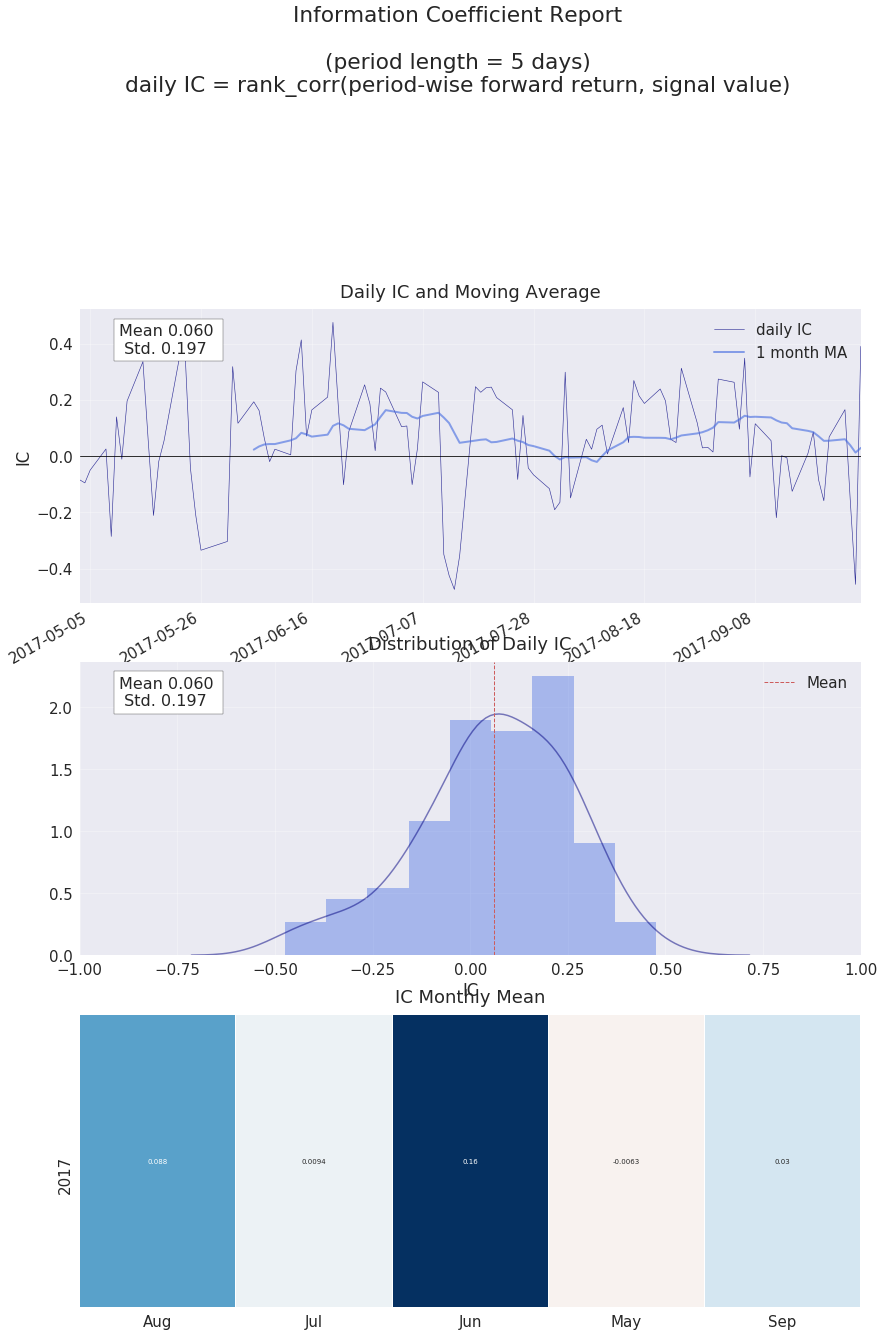

In [15]:
%matplotlib inline
td.create_information_report(sig_type="long")

## ic_report_data

- `jaqs_fxdayu.research.timingdigger.digger.TimingDigger.ic_report_data `

**简要描述：**

- ic分析相关数据
- 需要执行create_information_report后该属性才有值

**返回：**

dict of dict

由"long","short"所组成的字典（dict），每个字典里有'daily_ic'，'monthly_ic'所组成的字典(dict)

**示例：**

In [16]:
print(td.ic_report_data.keys())
print(td.ic_report_data["long"].keys())
td.ic_report_data["long"]["daily_ic"].head()

dict_keys(['long'])
dict_keys(['daily_ic', 'monthly_ic'])


,ic
trade_date,
2017-05-03,-0.084169
2017-05-04,-0.095228
2017-05-05,-0.049956
2017-05-08,0.025346
2017-05-09,-0.285701


## create_returns_report

- ` jaqs_fxdayu.research.timingdigger.digger.TimingDigger.create_returns_report(sig_type="long") `

**简要描述：**

- 收益分析
- 需要执行process_signal后才能执行该方法
- 注意：在process_signal里需要传入**因子类型**（非-2,2等离散事件）的enter_signal，并指定**n_quantiles**为大于1的正整数

**参数：**

|参数名|必选|类型|说明|
|:----    |:---|:----- |-----   |
|sig_type|否  |str（long/short）| 对何种信号进行收益分析。long:多头信号；short：空头信号。默认为"long" |


**返回：**

收益分析结果，并将结果保存至预设目录

**示例：**

Figure saved: /home/xinger/Desktop/jaqs_plus/jaqs-fxdayu/docs/_source/signal#sig_type:long_returns_report.pdf


<Figure size 432x288 with 0 Axes>

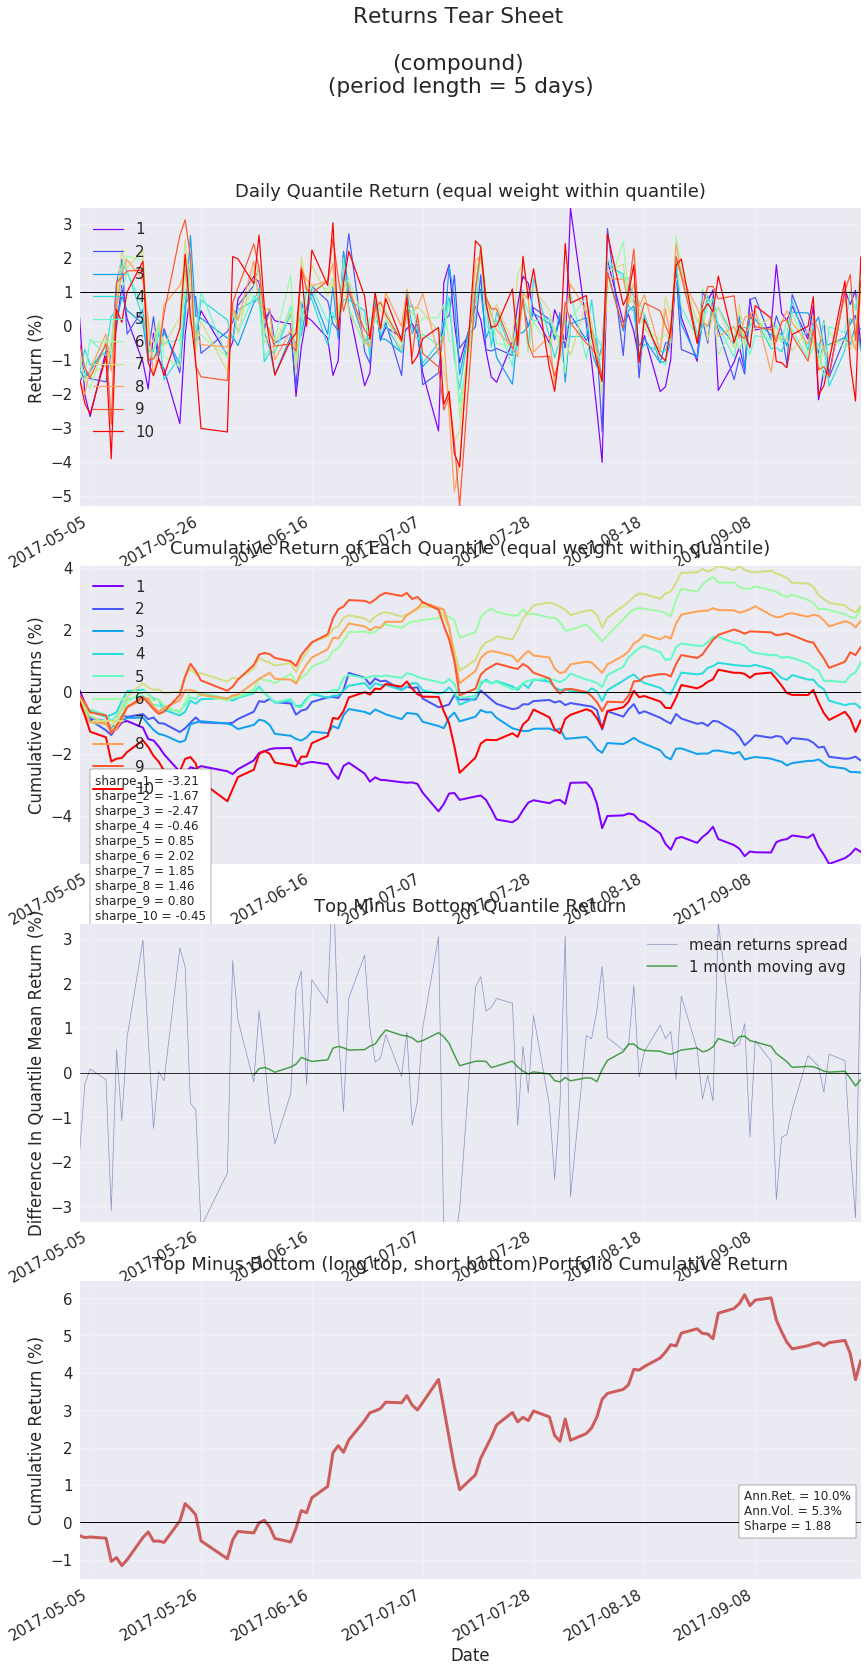

In [17]:
td.create_returns_report(sig_type="long")

## returns_report_data

- `jaqs_fxdayu.research.timingdigger.digger.TimingDigger.returns_report_data `

**简要描述：**

- 收益分析相关数据
- 需要执行create_returns_report后该属性才有值

**返回：**

dict of dict

由"long","short"所组成的字典（dict），每个字典里有'period_wise_quantile_ret'，'cum_quantile_ret'，'period_wise_tmb_ret', 'cum_tmb_ret'所组成的字典(dict)，分别对应：各quantile每日收益,quantile累积收益，top_quantile减bottom_quantile每日收益，top_quantile减bottom_quantile累积收益

**示例：**


In [18]:
print(td.returns_report_data.keys())
print(td.returns_report_data["long"].keys())
td.returns_report_data["long"]['cum_quantile_ret'].head()

dict_keys(['long'])
dict_keys(['period_wise_quantile_ret', 'cum_quantile_ret', 'period_wise_tmb_ret', 'cum_tmb_ret'])


,1,2,3,4,5,6,7,8,9,10
trade_date,,,,,,,,,,
2017-05-03,0.000461,-0.003362,-0.002655,-0.002772,-0.001981,-0.002838,-0.001764,-0.003193,-0.001035,-0.003120
2017-05-04,-0.003610,-0.006011,-0.005680,-0.004161,-0.004959,-0.006078,-0.004947,-0.007217,-0.003531,-0.007700
2017-05-05,-0.008959,-0.009132,-0.008367,-0.006498,-0.005749,-0.009786,-0.007799,-0.009803,-0.006595,-0.012889
2017-05-08,-0.010439,-0.012437,-0.009495,-0.008028,-0.007510,-0.010627,-0.010135,-0.010292,-0.007650,-0.014688
2017-05-09,-0.012084,-0.013976,-0.011228,-0.007466,-0.009382,-0.012356,-0.011041,-0.012972,-0.013465,-0.022527
